### In order to run the code the training and testing files should be in the same folder as that of the notebook

#### The datasets can be downloaded from https://www.kaggle.com/c/mercari-price-suggestion-challenge/data 

#### Please download all the .zip files and extract all of them. (important)

#### All the unziped datasets should be in the folder 'project' along with this jupyter notebook.

## Mercari Price Prediction Challenge

#### In this project the goal is to predict the price of the product based on name, item_condition, category_name, brand_name, shipping, item_description.

#### Since prediction is based on textual data,  RNN architecture is used to predict the price. 



### EDA and insights:

In [1]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
#read the dataset files
train = pd.read_csv('train.tsv', sep='\t')

In [3]:
#check for missing values
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [4]:
#fill missing values
def fill_missing_data(data):
    data.category_name.fillna(value = "Other/Other/Other", inplace = True)
    data.item_description.fillna(value = "No description yet", inplace = True)
    return data

train = fill_missing_data(train)

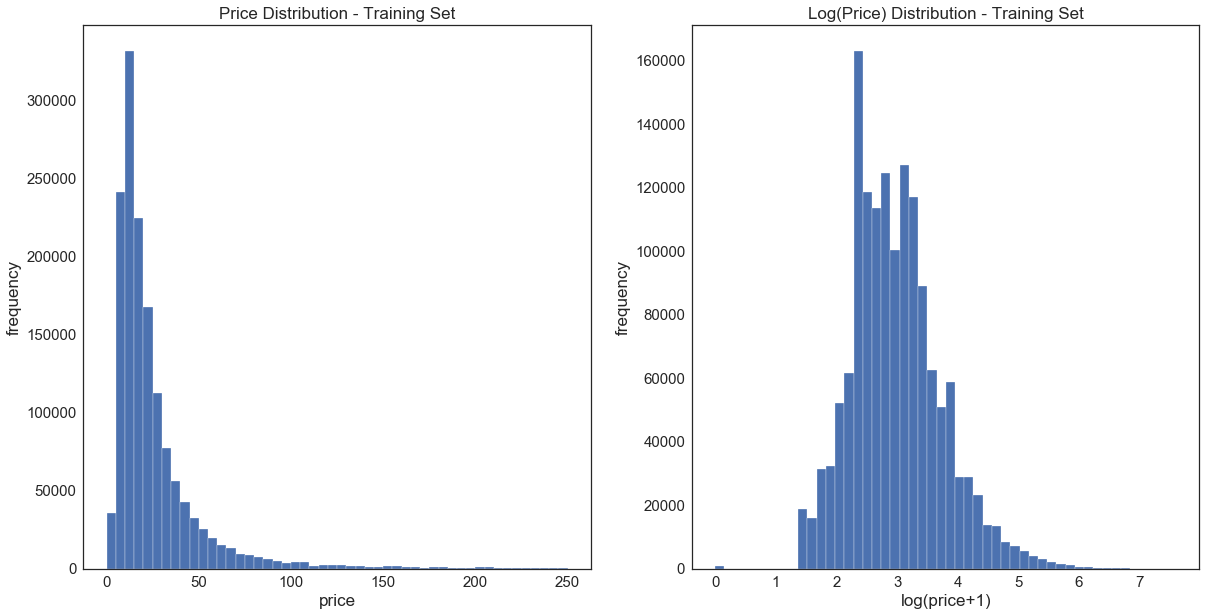

In [5]:
#frequency vs price plot
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

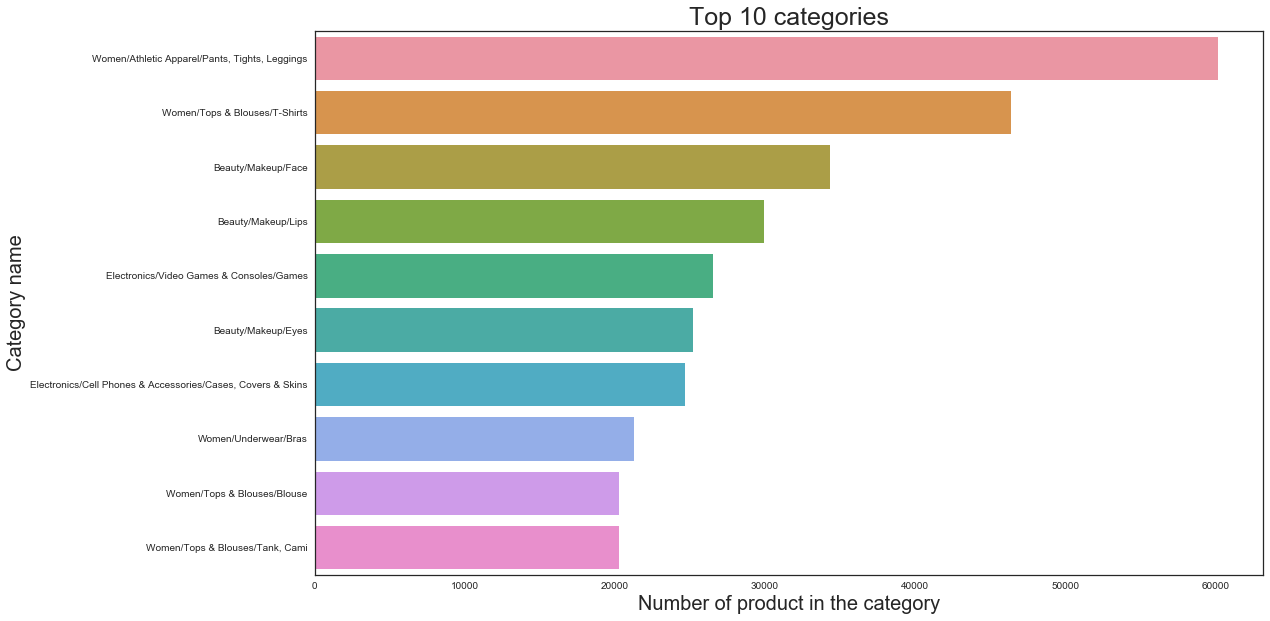

In [6]:
#top 10 number of categories by product
#women's rule the top 5 but does it also matter by price
plt.figure(figsize=(17,10))
sns.countplot(y = train.category_name, \
              order = train.category_name.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 categories', fontsize = 25)
plt.ylabel('Category name', fontsize = 20)
plt.xlabel('Number of product in the category', fontsize = 20)

In [7]:
#divide categories to subcategories
def cat_split(row):
    try:
        text = row
        txt1, txt2, txt3 = text.split('/')
        return txt1, txt2, txt3
    except:
        return np.nan, np.nan, np.nan


train["cat_1"], train["cat_2"], train["cat_3"] = zip(*train.category_name.apply(lambda val: cat_split(val)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


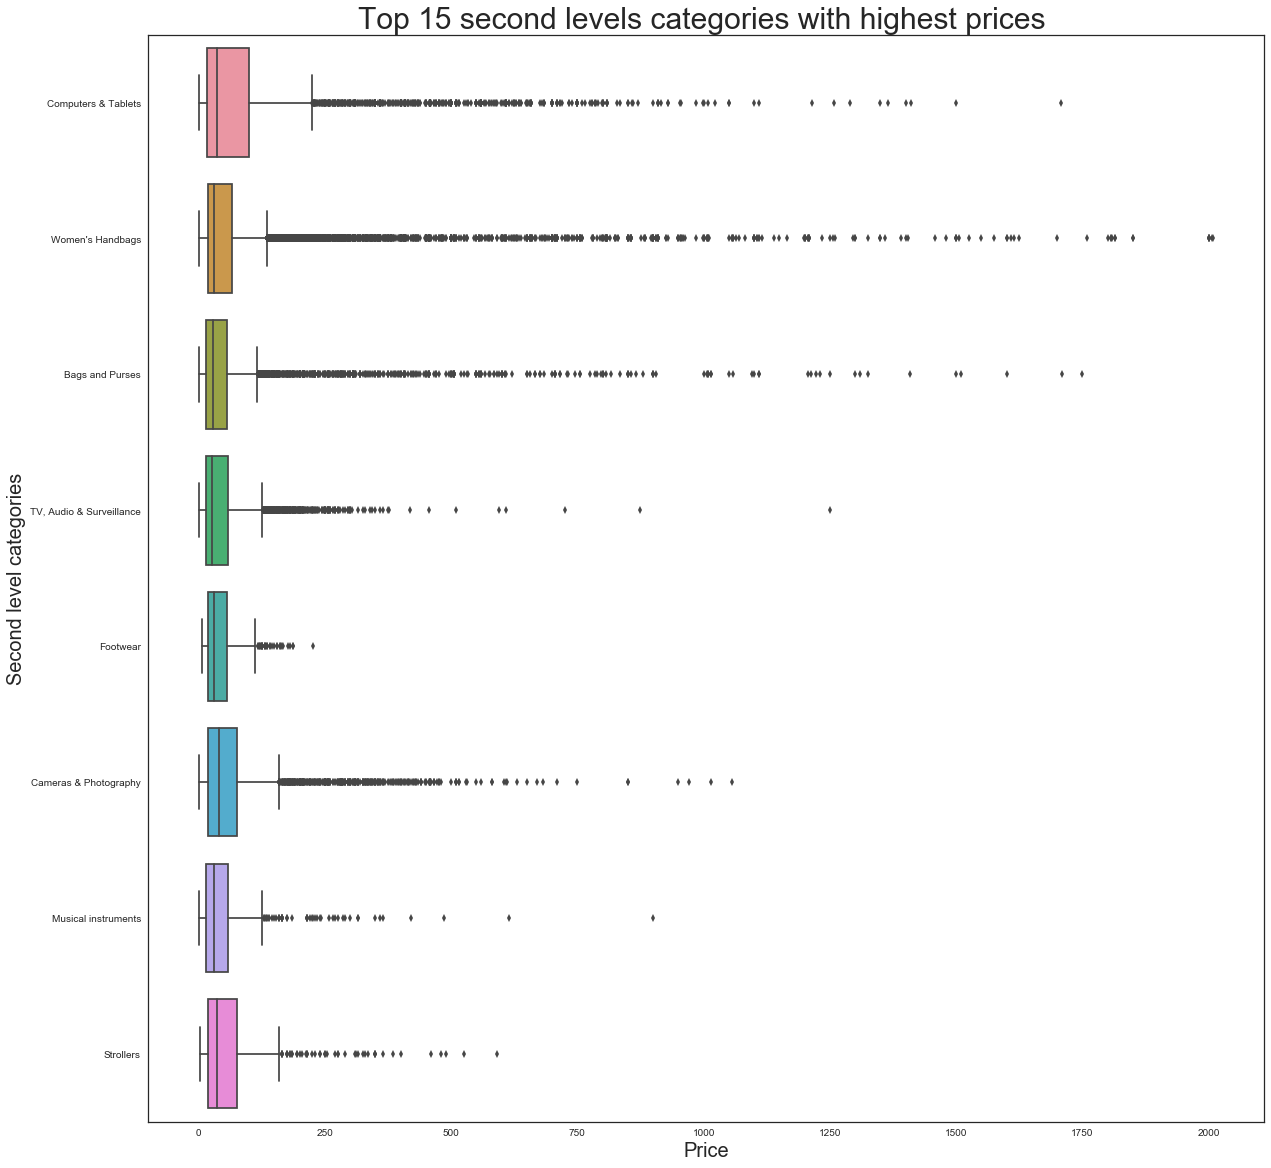

In [8]:
#We can see even though Women's handbags and purses have higher price the most expensive include electronics and kids strollers
level2 =  train.groupby('cat_2')
rank_level2 = pd.DataFrame(level2.mean()).sort_values(by='price')

#Then, we stock the top 15 most expensive into a list
top_cat2 = rank_level2.tail(8).reset_index()
top_cat2_list = top_cat2.cat_2.unique().tolist()
#We don't only want mean price by category, but all basics statistics, so we need the full series
top_cat2_full = train.loc[train['cat_2'].isin(top_cat2_list)]

#We can now plot it !
plt.figure(figsize=(20,20))
sns.boxplot(y ='cat_2',x= 'price', data = top_cat2_full, orient = 'h')
plt.title('Top 15 second levels categories with highest prices ', fontsize = 30)
plt.ylabel ('Second level categories', fontsize = 20)
plt.xlabel ('Price', fontsize = 20)

In [9]:
#Adding a new column log(price)
train["log_price"] = np.log(train["price"] + 1)
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,log_price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3.970292
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,2.397895
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,3.583519
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3.806662


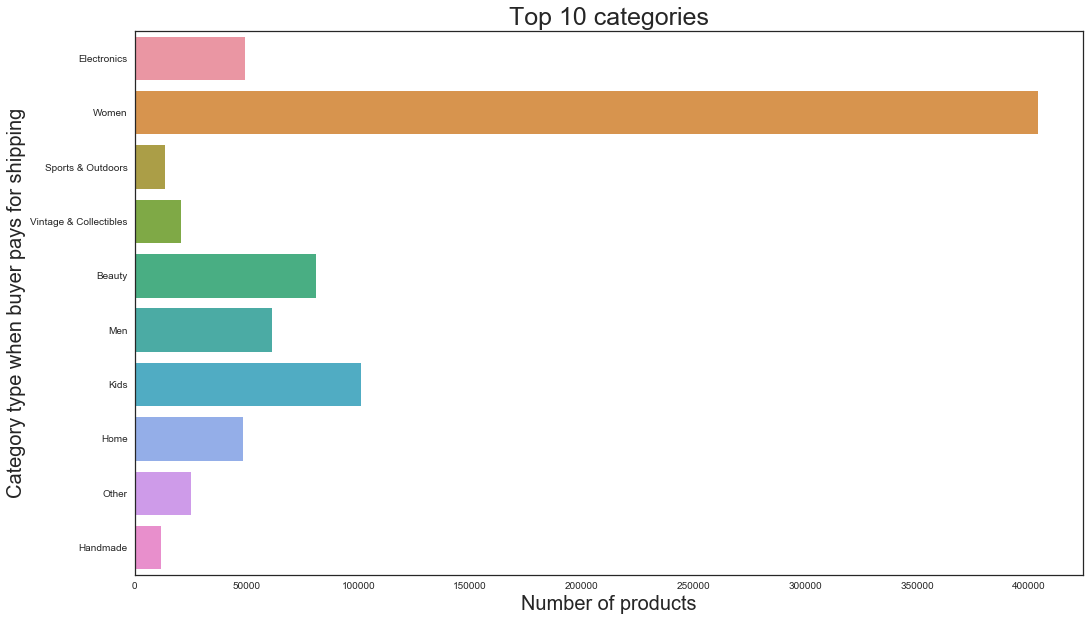

In [10]:
#top 3 categories by sales where we can say that buyer will pay the shipping regardless of price
in1=train[train['shipping'] == 0]

plt.figure(figsize=(17,10))
sns.countplot(y = in1.cat_1, orient = 'v')
plt.title('Top 10 categories', fontsize = 25)
plt.ylabel('Category type when buyer pays for shipping', fontsize = 20)
plt.xlabel('Number of products', fontsize = 20)

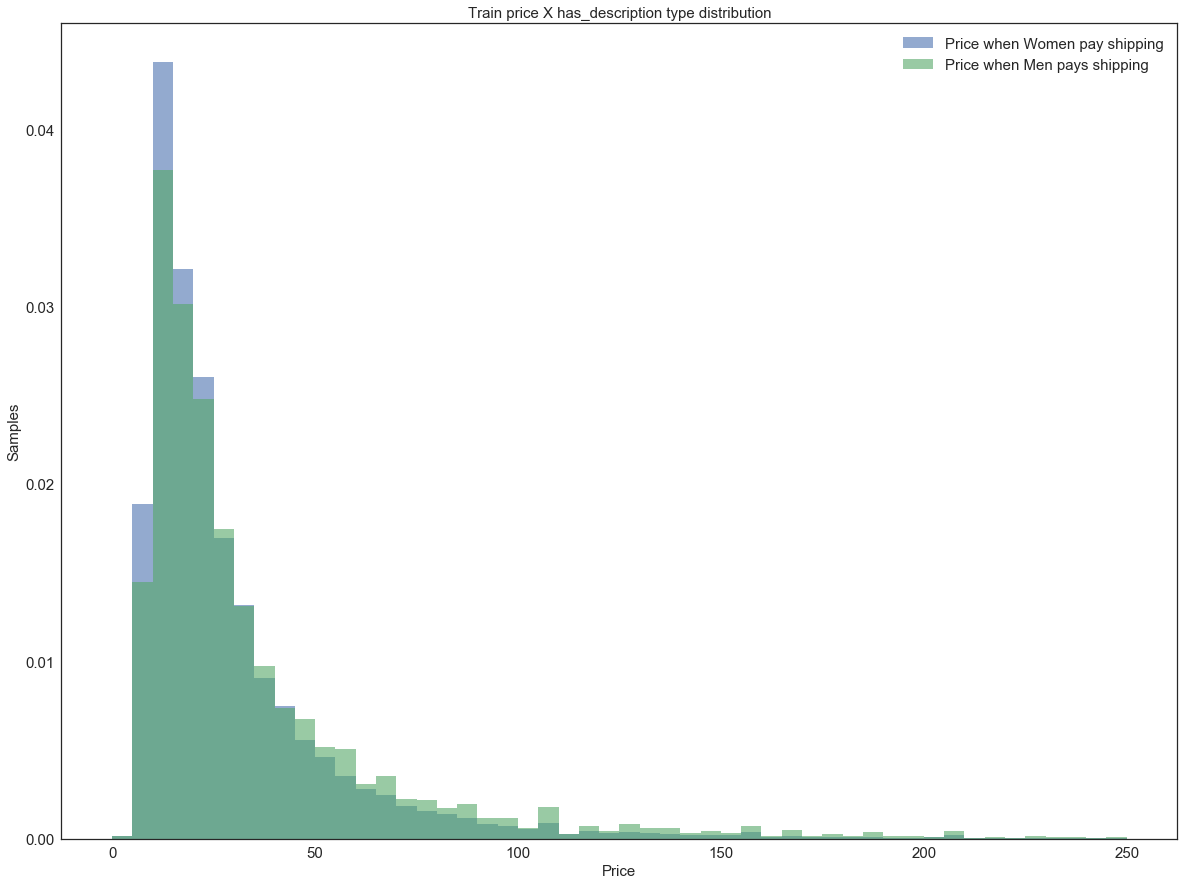

In [11]:
#We can See from this graph that Women or Men are willing to pay for shipping if the price is below 20 bucks
# we recommend that if the price is more than that they expect the seller to pay for shipping

plt.figure(figsize=(20, 15))
bins=50
plt.hist(in1[in1['cat_1']=='Women']['price'], bins,normed=True, range=[0,250],
         alpha=0.6, label='Price when Women pay shipping')
plt.hist(in1[in1['cat_1']=='Men']['price'], bins,normed=True,range=[0,250],
         alpha=0.6, label='Price when Men pays shipping')
plt.title('Train price X has_description type distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()


In [12]:
#function to give if brand name is there or not and return numerical value
def if_catname(row):
   
    if row == row:
        return 1
    else:
        return 0
    
train['if_cat'] = train.category_name.apply(lambda row : if_catname(row))
train.head()


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,log_price,if_cat
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,2.397895,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3.970292,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,2.397895,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,3.583519,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3.806662,1


In [13]:
#check number of unique brands
brands = train["brand_name"].nunique()
brands

4809

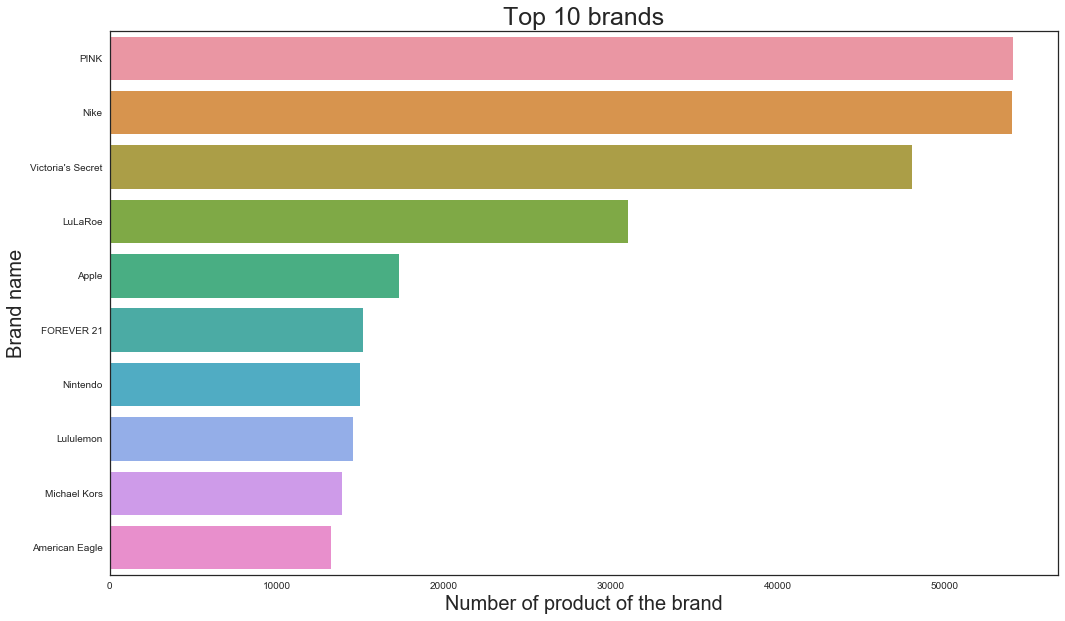

In [14]:
#We will check the most expensive brands in our dataset
plt.figure(figsize=(17,10))
sns.countplot(y = train.brand_name, \
              order = train.brand_name.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 brands', fontsize = 25)
plt.ylabel('Brand name', fontsize = 20)
plt.xlabel('Number of product of the brand', fontsize = 20)

In [15]:
#Lets check the shipping distribution for some insights
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

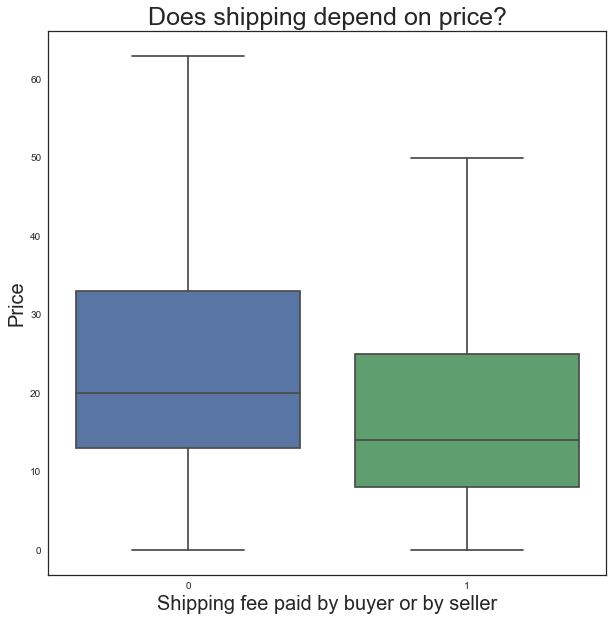

In [16]:
#shipping we think if the price is high seller should pay the shipping
#so we can recommend that even if the data is left skewed and shipper pays for 55% of all deliveries
# but the shipper pays when the price is high
plt.figure(figsize=(10,10))
sns.boxplot(x=train.shipping, y = train.price, showfliers=False, orient = 'v')
plt.title('Does shipping depend on price?', fontsize = 25)
plt.xlabel('Shipping fee paid by buyer or by seller', fontsize = 20)
plt.ylabel('Price', fontsize = 20)

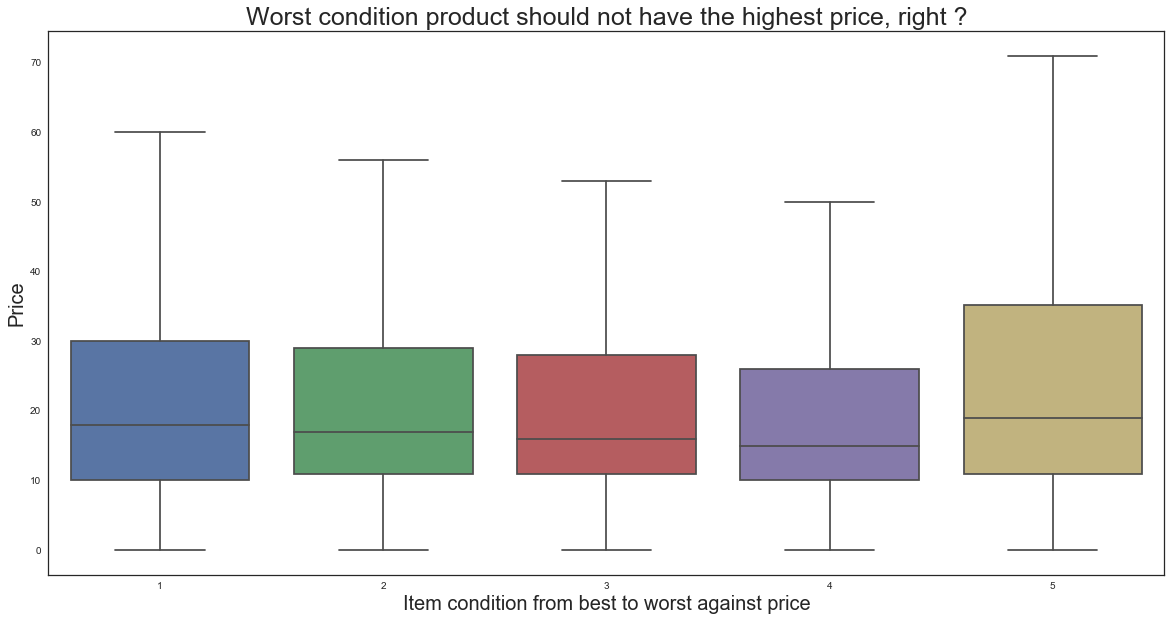

In [17]:
#We can see that condition_id=5 being the worst the price is unusually high
# so we recommend that ppl should not buy worst condition products by paying huge amounts of data
plt.figure(figsize=(20,10))
sns.boxplot(x=train.item_condition_id, y = train.price, showfliers=False, orient = 'v')
plt.title('Worst condition product should not have the highest price, right ?', fontsize = 25)
plt.xlabel('Item condition from best to worst against price', fontsize = 20)
plt.ylabel('Price', fontsize = 20)

In [18]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [19]:
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,log_price,if_cat,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,2.397895,1,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3.970292,1,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,2.397895,1,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,3.583519,1,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3.806662,1,3


In [20]:
train['desc_len'].describe()

count    1.482535e+06
mean     1.361367e+01
std      1.571437e+01
min      0.000000e+00
25%      4.000000e+00
50%      9.000000e+00
75%      1.600000e+01
max      1.360000e+02
Name: desc_len, dtype: float64